In [28]:
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)


/var/folders/3l/70h6qcrd72q0j5x4sscw7qn40000gn/T/ipykernel_3994/3025769522.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: mps
Number of workers: 10


<Figure size 640x480 with 0 Axes>

In [88]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [89]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [94]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None, apply_mask=False, contrastive_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform
        self.mask_transform = mask_transform
        self.apply_mask = apply_mask
        self.contrastive_transform = contrastive_transform


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        # Load corresponding mask
        mask_path = os.path.join(self.mask_dir, self.image_files[idx])
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale (single channel)

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Apply the mask to the image if apply_mask is True
        if self.apply_mask:
            image = self.apply_mask_to_image(image, mask)

        # Apply contrastive transform if provided (e.g., augmentations)
        if self.contrastive_transform:
            # If it's a single image, convert and apply contrastive transform directly
            if isinstance(image, torch.Tensor):
                image = transforms.ToPILImage()(image)
                image = self.contrastive_transform(image)
            
            return image, mask

    def apply_mask_to_image(self, image, mask):
        # Ensure the mask is binary (0 or 1)
        mask = (mask > 0).float()

        # Apply the mask to each channel of the image
        masked_image = image.clone()
        for c in range(3):  # For each RGB channel
            masked_image[c, :, :] *= mask[0, :, :]
        
        return masked_image

# Example transformations (ensure they convert images/masks to tensors correctly)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  # Convert mask to tensor directly
])

# Create dataset
dataset = ImageMaskDataset(
    image_dir='./data/Black Sea Sprat/Black Sea Sprat',
    mask_dir='./data/Black Sea Sprat/Black Sea Sprat GT',
    transform=transform,
    mask_transform=mask_transform,
    contrastive_transform=ContrastiveTransformations(contrast_transforms, n_views=2),
    apply_mask=True  # Set to True to apply the mask during preprocessing
)

# DataLoader for batching and shuffling
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Iterate through the DataLoader
for images, masks in data_loader:
    images=images
    masks=masks
    # print("Image batch shape:", images.size)  # (batch_size, channels, height, width)
    # print("Mask batch shape:", masks.size)    # (batch_size, 1, height, width)
    break


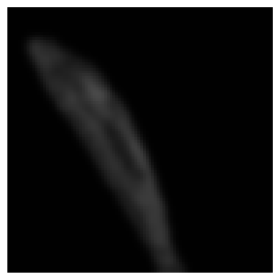

In [97]:
import matplotlib.pyplot as plt

# Convert the image tensor to numpy and permute dimensions
image = images[0][0].permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

# Since the image was normalized, we need to unnormalize it for display
image = image * 0.5 + 0.5  # Assuming normalization used mean=0.5, std=0.5

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Turn off the axis
plt.show()

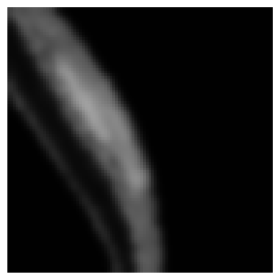

In [98]:
import matplotlib.pyplot as plt

# Convert the image tensor to numpy and permute dimensions
image = images[0][1].permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

# Since the image was normalized, we need to unnormalize it for display
image = image * 0.5 + 0.5  # Assuming normalization used mean=0.5, std=0.5

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Turn off the axis
plt.show()

In [99]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import os
import glob
import random

class ImageMaskDataset(Dataset):
    def __init__(
        self, 
        image_dirs, 
        mask_dirs=None, 
        transform=None, 
        mask_transform=None, 
        apply_mask=False, 
        contrastive_transform=None, 
        label_fraction=1.0,
        seed=42
    ):
        """
        Args:
            image_dirs (list): List of directories containing images.
            mask_dirs (list, optional): List of directories containing masks. 
                                        Should correspond to image_dirs if provided.
                                        If None, all images are considered unlabeled.
            transform (callable, optional): Transformations to apply to images.
            mask_transform (callable, optional): Transformations to apply to masks.
            apply_mask (bool, optional): Whether to apply masks to images.
            contrastive_transform (callable, optional): Additional transformations for contrastive learning.
            label_fraction (float, optional): Fraction of data to be labeled (between 0 and 1).
            seed (int, optional): Random seed for reproducibility.
        """
        self.image_dirs = image_dirs
        self.mask_dirs = mask_dirs if mask_dirs is not None else [None] * len(image_dirs)
        assert len(self.mask_dirs) == len(self.image_dirs), "mask_dirs must be the same length as image_dirs or None."

        self.transform = transform
        self.mask_transform = mask_transform
        self.apply_mask = apply_mask
        self.contrastive_transform = contrastive_transform
        self.label_fraction = label_fraction
        self.seed = seed

        self.image_files = []
        self.mask_files = []

        # Collect image and mask file paths
        for img_dir, msk_dir in zip(self.image_dirs, self.mask_dirs):
            imgs = glob.glob(os.path.join(img_dir, '*.jpg')) + \
                   glob.glob(os.path.join(img_dir, '*.jpeg')) + \
                   glob.glob(os.path.join(img_dir, '*.png'))
            self.image_files.extend(imgs)

            if msk_dir is not None:
                masks = glob.glob(os.path.join(msk_dir, '*.jpg')) + \
                        glob.glob(os.path.join(msk_dir, '*.jpeg')) + \
                        glob.glob(os.path.join(msk_dir, '*.png'))
                # Create a mapping from filename to mask path for quick lookup
                mask_dict = {os.path.basename(m): m for m in masks}
                for img_path in imgs:
                    img_name = os.path.basename(img_path)
                    mask_path = mask_dict.get(img_name, None)
                    if mask_path:
                        self.mask_files.append(mask_path)
                    else:
                        self.mask_files.append(None)
            else:
                # If no mask directories provided, all masks are None
                self.mask_files.extend([None] * len(imgs))

        assert len(self.image_files) == len(self.mask_files), "Number of images and masks must match."

        # Set random seed for reproducibility
        random.seed(self.seed)
        # Create indices and shuffle them
        self.indices = list(range(len(self.image_files)))
        random.shuffle(self.indices)

        # Determine number of labeled samples
        if self.label_fraction < 1.0 and any(self.mask_files):
            labeled_count = int(len(self.image_files) * self.label_fraction)
            # Ensure that we only count images that have masks
            labeled_indices = [idx for idx in self.indices if self.mask_files[idx] is not None]
            labeled_indices = labeled_indices[:labeled_count]
            self.labeled_set = set(labeled_indices)
        else:
            # All data is labeled
            self.labeled_set = set(idx for idx in self.indices if self.mask_files[idx] is not None)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        img_path = self.image_files[actual_idx]
        image = Image.open(img_path).convert('RGB')

        # Check if this sample is labeled
        is_labeled = actual_idx in self.labeled_set and self.mask_files[actual_idx] is not None

        if is_labeled:
            mask_path = self.mask_files[actual_idx]
            mask = Image.open(mask_path).convert('L')  # Grayscale
        else:
            mask = None

        # Apply transforms to image
        if self.transform:
            image = self.transform(image)

        # Apply transforms to mask if present
        if mask is not None and self.mask_transform:
            mask = self.mask_transform(mask)

        # Apply the mask to the image if required and if mask is present
        if self.apply_mask and mask is not None:
            image = self.apply_mask_to_image(image, mask)

        # Apply contrastive transform if provided
        if self.contrastive_transform:
            if isinstance(image, torch.Tensor):
                image_contrast = transforms.ToPILImage()(image)
                image_contrast = self.contrastive_transform(image_contrast)
            else:
                image_contrast = self.contrastive_transform(image)
            # Return both original and contrastively transformed images
            image = (image, image_contrast)

        if is_labeled:
            return image, mask  # (x, y)
        else:
            return image  # x

    def apply_mask_to_image(self, image, mask):
        """
        Applies a binary mask to the image.
        
        Args:
            image (Tensor): Image tensor of shape (3, H, W).
            mask (Tensor): Mask tensor of shape (1, H, W).
        
        Returns:
            Tensor: Masked image.
        """
        # Ensure the mask is binary
        mask = (mask > 0).float()

        # Expand mask to have the same number of channels as image
        if mask.shape[0] == 1 and image.shape[0] == 3:
            mask = mask.expand_as(image)

        # Apply the mask
        masked_image = image * mask

        return masked_image

    def get_unlabeled_dataset(self):
        """
        Returns a Subset of the dataset containing only unlabeled data.
        """
        unlabeled_indices = [idx for idx in range(len(self.image_files)) 
                             if idx not in self.labeled_set or self.mask_files[idx] is None]
        return Subset(self, unlabeled_indices)

    def get_labeled_dataset(self):
        """
        Returns a Subset of the dataset containing only labeled data.
        """
        labeled_indices = [idx for idx in range(len(self.image_files)) 
                           if idx in self.labeled_set and self.mask_files[idx] is not None]
        return Subset(self, labeled_indices)


In [100]:
import os

# Define image and mask directories
image_dirs = [os.path.abspath('data'+'/'+x+'/'+x) for x in os.listdir('data/') if not x.endswith('.txt') and not x.endswith('.m')]

mask_dirs = [os.path.abspath('data'+'/'+x+'/'+x +' GT') for x in os.listdir('data/') if not x.endswith('.txt') and not x.endswith('.m')]

# Example transformations (ensure they convert images/masks to tensors correctly)
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  # Convert mask to tensor directly
])



In [101]:
# Initialize the dataset
dataset = ImageMaskDataset(
    image_dirs=image_dirs,
    mask_dirs=mask_dirs,
    transform=image_transform,
    mask_transform=mask_transform,
    apply_mask=True,
    contrastive_transform=ContrastiveTransformations(contrast_transforms, n_views=1),
    label_fraction=0.7,  # 70% labeled, 30% unlabeled
    seed=123
)


In [102]:
# Create DataLoaders
batch_size = 16
num_workers = 4

# DataLoader for the entire dataset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)#, num_workers=num_workers)

In [103]:
# Alternatively, create separate DataLoaders for labeled and unlabeled data
labeled_dataset = dataset.get_labeled_dataset()
unlabeled_dataset = dataset.get_unlabeled_dataset()

labeled_dataloader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)#, num_workers=num_workers)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)#, num_workers=num_workers)

In [105]:
# Iterate through the DataLoader
for images, masks in labeled_dataloader:
    images=images
    masks=masks
    # print("Image batch shape:", images.size)  # (batch_size, channels, height, width)
    # print("Mask batch shape:", masks.size)    # (batch_size, 1, height, width)
    break

RuntimeError: each element in list of batch should be of equal size

In [104]:
# Iterate through the DataLoader
for batch in dataloader:
    if isinstance(batch, tuple) and len(batch) == 2:
        images, masks = batch
        print(f'Labeled batch - Images: {images.shape}, Masks: {masks.shape}')
    else:
        images = batch
        print(f'Unlabeled batch - Images: {images.shape}')
    # Add your training or processing code here
    break  # Remove this break to iterate through the entire dataset

# Example of iterating through labeled and unlabeled DataLoaders separately
for images, masks in labeled_dataloader:
    print(f'Labeled Data - Images: {images.shape}, Masks: {masks.shape}')
    # Training code for labeled data
    break

for images in unlabeled_dataloader:
    print(f'Unlabeled Data - Images: {images.shape}')
    # Training code for unlabeled data
    break

TypeError: expected Tensor as element 1 in argument 0, but got tuple

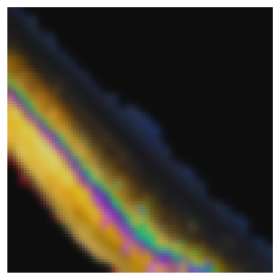

In [125]:
import matplotlib.pyplot as plt

# Convert the image tensor to numpy and permute dimensions
image = images[0][0].permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

# Since the image was normalized, we need to unnormalize it for display
image = image * 0.5 + 0.5  # Assuming normalization used mean=0.5, std=0.5

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Turn off the axis
plt.show()

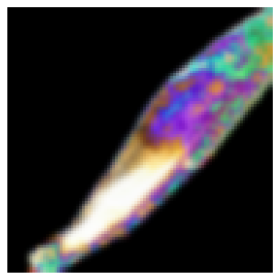

In [126]:
import matplotlib.pyplot as plt

# Convert the image tensor to numpy and permute dimensions
image = images[0][1].permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

# Since the image was normalized, we need to unnormalize it for display
image = image * 0.5 + 0.5  # Assuming normalization used mean=0.5, std=0.5

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Turn off the axis
plt.show()

Seed set to 42


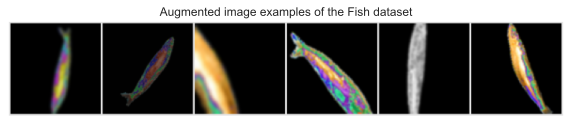

In [128]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in dataset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the Fish dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [129]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [ ]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
